# 2. Quantizing models and embeddings

In [3]:
import os
import time
import torch
import pandas as pd
import numpy as np
from torch import nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, confusion_matrix
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
import random
import pickle
import sys
# !pip install qnet
sys.path.insert(0, os.path.abspath('../'))
from qnet import *
from calflops import calculate_flops

In [4]:
# Set up default configuration using a namespace
class Args:
    data_path = '/home/sebastian/codes/repo_clean/VE_paper/0_VE_extraction/E_NET_EMBEDDINGS/urban8k_efficientnet_b3/efficientnet_b3_1536_bs64'
    output_dir = 'output'
    total_num_seed = 1
    num_classes = 5
    num_epochs = 5
    batch_size = 64
    learning_rate = 1e-3
    model = 'mlp'
    device = 'cpu'#'cuda' if torch.cuda.is_available() else 'cpu'
    pca = False
    variance_threshold = 0.8

args = Args()

# Fix paths to use current working directory
device = torch.device(args.device)
print(f"Using device: {device}")

Using device: cpu


SEED 0
--------------------------------
Train data: /home/sebastian/codes/repo_clean/VE_paper/0_VE_extraction/E_NET_EMBEDDINGS/urban8k_efficientnet_b3/efficientnet_b3_1536_bs64/train_embeddings.csv
Val data: /home/sebastian/codes/repo_clean/VE_paper/0_VE_extraction/E_NET_EMBEDDINGS/urban8k_efficientnet_b3/efficientnet_b3_1536_bs64/val_embeddings.csv
Reset trainable parameters of layer = Linear(in_features=1536, out_features=256, bias=True)
Reset trainable parameters of layer = LayerNorm((256,), eps=1e-05, elementwise_affine=True)
Reset trainable parameters of layer = Linear(in_features=256, out_features=128, bias=True)
Reset trainable parameters of layer = LayerNorm((128,), eps=1e-05, elementwise_affine=True)
Reset trainable parameters of layer = Linear(in_features=128, out_features=64, bias=True)
Reset trainable parameters of layer = LayerNorm((64,), eps=1e-05, elementwise_affine=True)
Reset trainable parameters of layer = Linear(in_features=64, out_features=5, bias=True)
Epoch 1/5, F

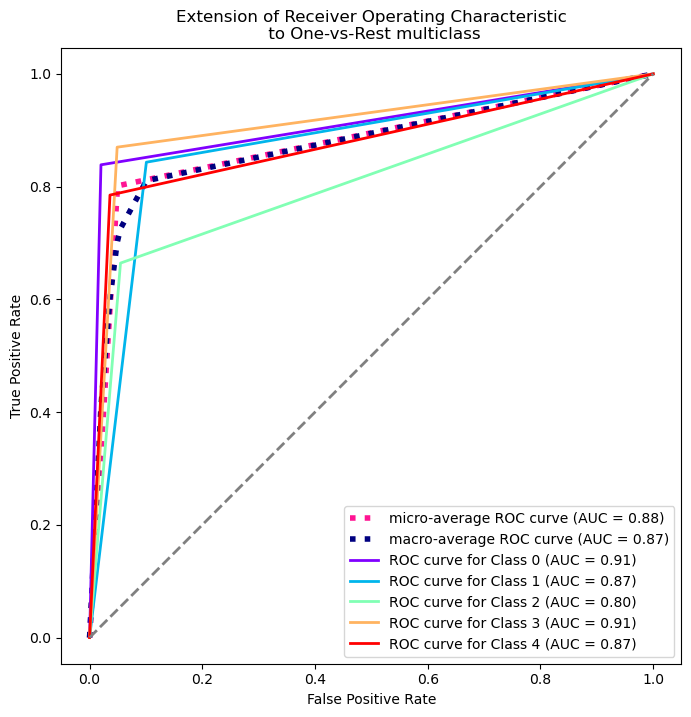

In [15]:
for seed in range(args.total_num_seed):
    print(f'SEED {seed}')
    print('--------------------------------')
    
    train_csv = os.path.join(args.data_path, 'train_embeddings.csv')
    val_csv = os.path.join(args.data_path, 'val_embeddings.csv')
    print(f"Train data: {train_csv}")
    print(f"Val data: {val_csv}")
    
    experiment_folder = f"{args.model}_{args.data_path.split('/')[-1]}"
    experiment_folder += f"_combined"
    
    # Create output directories
    output_folder = os.path.join(os.getcwd(), args.output_dir, experiment_folder)
    seed_dir = os.path.join(output_folder, f"seed_{seed}")
    quantized_dir = os.path.join(output_folder, f"experiment_folder_quantizedVE")

    os.makedirs(quantized_dir, exist_ok=True)

    os.makedirs(seed_dir, exist_ok=True)

    
    # Load datasets
    train_dataset = QuantizedEmbeddingDataset(train_csv, save_dir=quantized_dir, train=True, save_embeddings=False)
    val_dataset = QuantizedEmbeddingDataset(val_csv, save_dir=quantized_dir, train=False, save_embeddings=False)

    # train_dataset = QuantizedEmbeddingDataset(train_csv, train=True) if quantized_data \
    #                 else EmbeddingDataset(train_csv, shuffle=True)
    # val_dataset = QuantizedEmbeddingDataset(val_csv, train=False) if quantized_data \
    #               else EmbeddingDataset(val_csv, shuffle=False)

    train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False)
    
    # # Get dataset statistics
    # num_features = train_dataset[0][0].shape[0]
    class_labels = np.unique(train_dataset.labels)

    # class_counts = np.bincount(np.asarray(train_dataset.labels, int))
    # class_weights = 1.0 / class_counts
    # class_weights = torch.tensor(class_weights, dtype=torch.float32)

    class_counts = np.bincount(np.asarray(train_dataset.labels, int))
    class_weights = 1.0 / class_counts
    class_weights = torch.tensor(class_weights, dtype=torch.float32)
    
    patience = 50  
    best_f1 = 0.0
    patience_counter = 0    
    
    if args.model == 'mlp':
        torch.manual_seed(seed)
        np.random.seed(seed)
        class_weights = class_weights.to(device)
        
        # Model initialization with correct input size
        original_model = SClassifier(train_dataset[0][0].shape[0], 
                                   args.num_classes, 
                                   hidden_sizes=[256, 128, 64]).to(device)
        original_model.apply(reset_weights)
        
        optimizer = torch.optim.Adam(original_model.parameters(), lr=args.learning_rate)
        criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)
        scheduler = ReduceLROnPlateau(optimizer, 'max', patience=5, factor=0.8)

        train_losses = []
        val_losses = []
        start_train_time = time.time()
        
        for epoch in range(args.num_epochs):
            original_model.train()
            epoch_train_loss = 0.0
            
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device) 
                optimizer.zero_grad()
                outputs = original_model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                epoch_train_loss += loss.item() * inputs.size(0)
            
            # Validation
            original_model.eval()
            epoch_train_loss /= len(train_loader.dataset)
            train_losses.append(epoch_train_loss)
            
            all_labels, all_preds = [], []
            epoch_val_loss = 0.0
            
            with torch.inference_mode():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device) 
                    outputs = original_model(inputs)
                    loss = criterion(outputs, labels)
                    epoch_val_loss += loss.item() * inputs.size(0)
                    _, predicted = torch.max(outputs.data, 1)
                    all_labels.extend(labels.cpu().numpy())
                    all_preds.extend(predicted.cpu().numpy())
            
            epoch_val_loss /= len(val_loader.dataset)
            val_losses.append(epoch_val_loss)

            f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
            print(f'Epoch {epoch+1}/{args.num_epochs}, F1 Score: {f1:.4f}')
            scheduler.step(f1)
            
            if f1 > best_f1:
                best_f1 = f1
                patience_counter = 0
                torch.save(original_model.state_dict(), os.path.join(seed_dir, 'best_model.pth'))
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print("Early stopping triggered")
                break

        # Post-training quantization
        print("Applying model quantization...")
        model = torch.quantization.quantize_dynamic(
                original_model,
                {nn.Linear},
                dtype=torch.qint8
        )
        model.eval()
        for param in model.parameters():
                param.requires_grad_(False)
            
        f=print_size_of_model(model,"fp32")
        q=print_size_of_model(original_model,"int8")
        print("{0:.2f} times smaller".format(f/q))
        
        # Final evaluation
        start_inference_time = time.time()
        all_labels, all_preds = [], []
        with torch.inference_mode():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device) 
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())
        
        training_time = time.time() - start_train_time
        inference_time = time.time() - start_inference_time
        model_memory = get_memory_usage()
        
        # Generate plots
        plot_losses(train_losses, val_losses, seed_dir)
        plot_multiclass_roc_curve(all_labels, all_preds, seed_dir)
        save_confusion_matrix(all_labels, all_preds, np.unique(train_dataset.labels), seed_dir, "val")
        
    flops, macs, params = calculate_flops(model=model, 
                                      input_shape=(1, train_dataset.features.shape[1]), 
                                      output_as_string=False,
                                      output_precision=4)
    
    # Calculate metrics
    metrics = {
        'EMB_size_out': train_dataset[0][0].shape[0],
        'Accuracy': accuracy_score(all_labels, all_preds),
        'F1 Score': f1_score(all_labels, all_preds, average='weighted', zero_division=0),
        'F0.75 Score': fbeta_score(all_labels, all_preds, beta=0.75, average='weighted', zero_division=0),
        'Precision': precision_score(all_labels, all_preds, average='weighted', zero_division=0),
        'Recall': recall_score(all_labels, all_preds, average='weighted', zero_division=0),
        'Training time (s)': round(training_time, 2),
        'Inference time (s)': round(inference_time, 2),
        'Memory RAM (MB)': round(model_memory, 2),
        'KFLOPS':flops/1e3,
        'KMACS':macs/1e3,
        'KPARAMS':params/1e3
    }
    print(metrics)
    
    save_predictions(seed_dir, experiment_folder, model, metrics, all_labels, all_preds, seed)

consolidate_and_average_metrics(args, output_folder)
print("Evaluation across different seeds completed. Results saved to:", output_folder)